In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import optimize
import random

In [96]:
T = pd.read_csv('/Users/siyangwei/Documents/ANES_datasets/anes_timeseries_cdf_csv_20220916/anes_timeseries_cdf_csv_20220916.csv',
                low_memory=False)
T['VCF0101'] = pd.to_numeric(T['VCF0101'],errors='coerce',downcast='integer')
T = T[T['VCF0101']<=80]   # restrict age <= 80
T['VCF0004'] = pd.to_numeric(T['VCF0004'],errors='coerce',downcast='integer')
year = T['VCF0004']       
yr = set(year)      # extract survey years
age = T['VCF0101']       # extract respondent age
M = pd.concat([year,age],axis=1,join='inner')

In [143]:
# import real US matrix
Wim = pd.read_excel('/Users/siyangwei/Documents/contact_matrices_152_countries/MUestimates_all_locations_2.xlsx',
                   sheet_name = 53, header = None)
Wim = Wim.to_numpy()
N = 16
Wc = np.ones([N,N])
# symmetrized US matrix
# scale WUS such that the first row and col both sums to 1
Wnml = np.copy(Wim)
# sc = sum(WUS[1:N,0])/(1-Wnml[0,0])
# Wnml[1:N,0] = WUS[1:N,0]/sc
Wsym = (Wnml + np.transpose(Wnml))/2
W = np.copy(Wc)

/Users/siyangwei/anaconda3/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [225]:
# Analyze a question
varname = 'VCF9243'   
# 1970 type of this question, 0009: 0, 0010: 1, 0011: 2
weightvar = 'VCF0009z'
if varname == 'VCF0816':
    weightvar = 'VCF0011z'
weight = T[weightvar]  
var = T[varname]
var = T[varname].astype('category')
D = M.join(var,how='inner')
Dw = D.join(weight, how = 'inner')
I = np.zeros([len(yr),5,13])  # 3d array, year, type and type percentage, 13 age groups
J = np.zeros([len(yr),5])  # 2d array, year, type and type percentage
yr = list(yr)
J[:,0] = yr;

for j in range(13): # 13 age groups
    
    # extract data for age group j
    maskj = (age > 5*(j+3)) & (age <= 5*(j+4))
    Mag = Dw[maskj == True]
    
    # count for each year
    I[:,0,j] = yr
    for i in range(len(yr)):
        maskyr = (Mag['VCF0004'] == yr[i])
        Magyr = Mag[maskyr == True]
        # number of opinion 1 in year i, age group j
        I[i,1,j] = Magyr.loc[Magyr[varname] == '1', weightvar].sum()
        I[i,2,j] = Magyr.loc[Magyr[varname] == '2', weightvar].sum()
        #I[i,1,j] = sum(Magyr[varname] == '1')
        #I[i,2,j] = sum(Magyr[varname] == '2')
        # number of opinion 1 in year i, all age groups
        J[i,1] += I[i,1,j]
        J[i,2] += I[i,2,j]

# delete the year without data for I and J
J2 = J[:,[1,2]]
J = J[~np.all(J2 == 0, axis = 1)]
t = J[:,0]
In = np.zeros([len(t),5,13])
for k in range(13):
    ind = np.isin(I[:,0,k],t)
    In[:,:,k] = I[ind,:,k]

np.seterr(invalid='ignore') # ignore 0/0 error, will return NaN
# compute opinion 1/ population of each year
In[:,3,:] = In[:,1,:]/np.sum(In[:,[1,2],:],1)
In[:,4,:] = In[:,2,:]/np.sum(In[:,[1,2],:],1)

J[:,3] = J[:,1]/np.sum(J[:,[1,2]],1)
J[:,4] = J[:,2]/np.sum(J[:,[1,2]],1)

# Initial Conditions
tmax = int((t[-1]-t[0]+5)//5 + 1) # ceil division, time gap = age group diff = 5 years
taxis = np.arange(0,tmax)*5 + t[0]
# use the same initial condition as in dataset
p = np.zeros([N,tmax])

# deal with NaN values: replace NaN with average
# p0[np.isnan(p0)] = np.mean(p0[~np.isnan(p0)])
# intead of replacing with average, replace NaN with the next available value in this age group
for i in range(3,N):
    if In[0,3,i-3] != In[0,3,i-3]:
        p[i,0] = next((x for x in In[:,3,i-3] if x == x))
    else:
        p[i,0] = In[0,3,i-3]
        
p[0:3,0] = In[0,3,2:5] # IC for age 0-15: assume the same as IC for age 25-40
p0 = p[:,0]

In [226]:
# simulation given be and ga
# be and ga are 2d arrays: size N*(tmax-1)
def sim(be,ga):
    p = np.zeros([N, tmax])
    p[:, 0] = p0
    for i in range(tmax-1):
        p[0,i+1] = np.dot(W[0,:],p[:,i])/sum(W[0,:])
        for gp in range(1,N):
            p[gp,i+1] = np.dot(p[gp-1,i],(1-be[gp,i]*np.dot(W[gp,:],(1-p[:,i])))) \
            + np.dot((1-p[gp-1,i]),ga[gp,i]*np.dot(W[gp,:],p[:,i]))
    return p

In [227]:
# sse for linear, coordinated age and time-dependent model
# beta_t = c+a+gi+ft, gamma_t = c-a-gi-ft
def Jlcit(param):
    c = param[0]
    a = param[1]
    gg = param[2]
    f = param[3]
    sse = 0
    be = np.fromfunction(lambda i, j: c + a + gg * i + f * j, (N, tmax-1))
    ga = np.fromfunction(lambda i, j: c - a - gg * i - f * j, (N, tmax-1))
    p = sim(be, ga)
    for k in range(13):
        kindex = ~np.isnan(In[:,3,k])
        pinterp = np.interp(t[kindex], taxis, p[k+3,:])
        sse += np.sum(np.square(pinterp - In[kindex,3,k]))
    return sse

In [228]:
# backtracking line search
def BTLS(fun, w, dw, c = 0.01, gam = 0.5):
    fw = fun(w)
    dwnorm = np.linalg.norm(dw)
    d = -dw * 1e-5 / dwnorm     # descent direction
    deltaf = -c * 1e-5 * dwnorm
    newf = fun(w + d)
    t = 1
    while newf > fw + t * deltaf:
        t = gam * t
        newf = fun(w + t * d)
    return t, d

In [229]:
def grad_descent(fun,w_init, maxIter=500):
    w = w_init
    dw = np.ones(w_init.shape)
    W = []
    costs = []
    n_iter = 0
    
    W.append(w.copy())
    costs.append(fun(w))
    
    while n_iter < maxIter:
        # gradient of fun w.r.t. w
        dw = optimize.approx_fprime(w,fun,epsilon=1.4901161193847656e-08)
        if np.linalg.norm(dw) < 1e-8:
            break
            
        # adaptively choose step size
        lr, d = BTLS(fun, w, dw)
        w = w + lr * d
        
        cost = fun(w)

        be = np.fromfunction(lambda i, j: w[0] + w[1] + w[2] * i + w[3] * j, (N, tmax-1))
        ga = np.fromfunction(lambda i, j: w[0] - w[1] - w[2] * i - w[3] * j, (N, tmax-1))
                
        if be.max()>1 or be.min()<0 or ga.max()>1 or ga.min()<0:
            break
        else:
            W.append(w.copy())
            costs.append(cost)
            n_iter += 1    
    
    return W, costs

In [230]:
# import best parameters for linear,coordinated,age-dependent model
# Read the CSV file into a DataFrame object
df = pd.read_csv('/Users/siyangwei/Documents/Python/OpinionDynamics/binaryweightedcoeffWc.csv')
df2 = df['Age Model LC']
ind = df.index[df['Question'] == varname].tolist()[0]
coeff2 = df2[df2.index % 3 == 2]
costr2 = coeff2[ind + 2].split(']')[0].split('[')[1:][0].split()
lciopt = [0,0,0,0]
lciopt[0], lciopt[1], lciopt[2] = float(costr2[0]),float(costr2[1]),float(costr2[2])
sselci = Jlcit(lciopt)
df5 = df['Time Model LC']
coeff5 = df5[df5.index%3==2]
costr5 = coeff5[ind + 2].split(']')[0].split('[')[1:][0].split()
lctopt = [0,0,0,0]
lctopt[0], lctopt[1], lctopt[3] = float(costr5[0]),float(costr5[1]),float(costr5[2])
sselct = Jlcit(lctopt)

In [231]:
#linear coordinated, age and time-dependent model
i = 0
nt = 1000
paramrec = np.zeros((4,nt))
costrec = np.zeros(nt)
while i < nt:
    init = np.zeros(4)
    if i == 0:
        init = np.array(lciopt)
    elif i == 1:
        init = np.array(lctopt)
    else:
        init[0] = random.uniform(0,0.1)
        init[1] = random.uniform(-0.1,0.1)
        init[2] = random.uniform(-0.001, 0.001)
        init[3] = random.uniform(-0.001, 0.001)
    beinit = np.fromfunction(lambda i, j: init[0] + init[1] + init[2] * i + init[3] * j, (N, tmax-1))
    gainit = np.fromfunction(lambda i, j: init[0] - init[1] - init[2] * i - init[3] * j, (N, tmax-1))
    safe = True
    for k in range(tmax-1):
        for j in range(1, N):
            if beinit[j,k]*sum(W[j,:])>1 or gainit[j,k]*sum(W[j,:])>1:
                safe = False
                break
    if safe and beinit.min() >= 0 and beinit.max() <= 1 and gainit.min() >= 0 and gainit.max() <= 1:
        paramrec[:, i] = init
        costrec[i] = Jlcit(init)
        params, costs = grad_descent(Jlcit,init)
        lcitopt = params[-1]
        be = np.fromfunction(lambda i, j: lcitopt[0] + lcitopt[1] + lcitopt[2] * i + lcitopt[3] * j, (N, tmax-1))
        ga = np.fromfunction(lambda i, j: lcitopt[0] - lcitopt[1] - lcitopt[2] * i - lcitopt[3] * j, (N, tmax-1))
        safe = True
        for k in range(tmax-1):
            for j in range(1, N):
                if be[j,k]*sum(W[j,:]) > 1 or ga[j,k]*sum(W[j, :])>1:
                    safe = False
        if np.isnan(params[-1]).any():
            continue
        if len(costs) >= 1 and min(costs) > 0 and safe:
            paramrec[:,i] = params[-1]
            costrec[i] = costs[-1]
            if i % 100 == 0:
                print(i, min(costrec[:i+1]))
            i += 1
        elif i == 0 or i == 1:
            i += 1
    

sselcit = min(costrec)
besti = np.argmin(costrec)
lcitopt = paramrec[:,besti]
print('minimum SSE for linear, coordinated, age and time-dependent model:',round(sselcit,4))
print('parameters:',np.around(lcitopt,decimals = 5))

0 0.476505253021722
100 0.476505253021722
200 0.476505253021722
300 0.476505253021722
400 0.476505253021722
500 0.476505253021722
600 0.476505253021722
700 0.476505253021722
800 0.476505253021722
900 0.476505253021722
minimum SSE for linear, coordinated, age and time-dependent model: 0.4765
parameters: [ 4.842e-02  2.260e-03 -5.200e-04  1.000e-05]


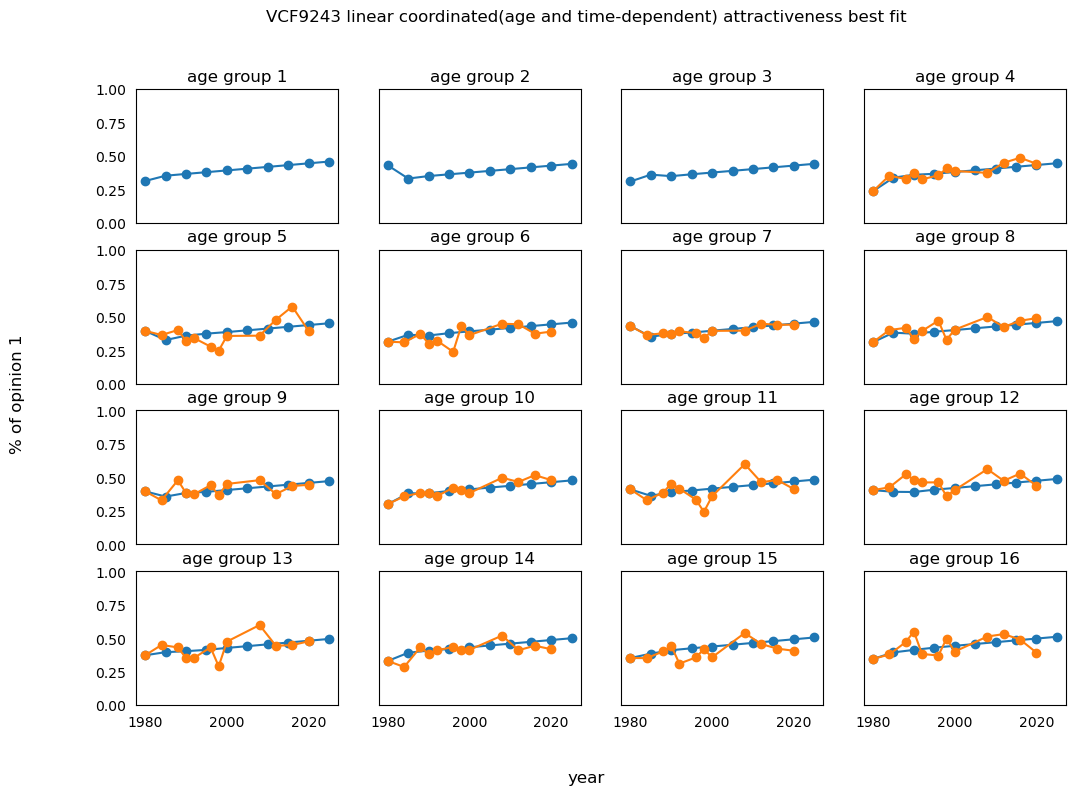

In [232]:
be = np.fromfunction(lambda i, j: lcitopt[0] + lcitopt[1] + lcitopt[2] * i + lcitopt[3] * j, (N, tmax-1))
ga = np.fromfunction(lambda i, j: lcitopt[0] - lcitopt[1] - lcitopt[2] * i - lcitopt[3] * j, (N, tmax-1))
# sanity check
for k in range(tmax-1):
    for i in range(1, N):
        if be[i, k]*sum(W[i,:]) > 1 or ga[i,k]*sum(W[i, :])>1:
            print('Warning')
p = sim(be, ga)
# time series graph for every age group
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
for k in range(16):
    [i,j] = np.unravel_index(k,[4,4])
    axs[i,j].plot(taxis,p[k,:],'-o')
    if k in range(3,16):
        axs[i,j].plot(t,In[:,3,k-3],'-o')
    axs[i,j].tick_params(left = False, bottom = False)
    axs[i,j].set_title('age group '+str(k+1))
    axs[i,j].set_ylim(0,1)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle(varname + ' linear coordinated(age and time-dependent) attractiveness best fit')
fig.supxlabel('year')
fig.supylabel('% of opinion 1')
plt.savefig('2opinionweightedfits/lcitfit'+varname+'Wc.jpg')
plt.show()

In [233]:
def AIC(k, N, SSE):
    return 2*k + N * math.log(SSE/N)
# number of data points
ndp = np.count_nonzero(~np.isnan(In[:,3,:]))
aic8 = AIC(4, ndp, sselcit)
print('AIC FOR MODEL 8', np.around(aic8, decimals=4))
print('Linear, coordinated model: ', round(sselcit,4), '\n', np.around(lcitopt,decimals=5))

AIC FOR MODEL 8 -895.4167
Linear, coordinated model:  0.4765 
 [ 4.842e-02  2.260e-03 -5.200e-04  1.000e-05]
